#  Introduction to DGSnapshot


The goal of this notebook is to provide an overview of the DGSnapshot API and introduce some common workflow patterns that take advantage of the DGSnapshot functionality. DGSnapshot and its dependencies are pre-installed on instances of DGKernels, where it can be used in conjunction with the image selection plugin to quickly create workflows involving image data acquisition, organization, storage and exploration a more seamless experience.    

Requirements:


* Access to a GeoJSON file referencing Idaho image footprints. These are created automatically when selecting imagery in a DGKernel, drawing a bounding box and saving a collection of image references.

In [8]:
# replace "EXAMPLE_FILENAME.json" line with the name of your geojson collection file, eg, 
# "my_collection.json", including the quotes. 

collection_name = "EXAMPLE_FILENAME.json"
# If you have a GBDX token, you can use it to call a preview method, as discussed later on. Replace None below with 
# your token, if you have access to one. Make sure it's a string (put quotes around it like above).

gbdx_token = None

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

from timbr.dgsnapshot import DGSnapshot

In [2]:
# Create the snapshot for the first time using the "from_geojson" method:
dgsnap = DGSnapshot.from_geojson(collection_name)

/Users/jamiepolackwich1/Timbr/testing_notebooks/tmp/00712e96-d6fb-4dbf-ab1f-a22274f130cf.TOAReflectance.0.vrt


In [ ]:
# The indexes of the snapshot are references of the original GeoJSON features in your collection. 
# See how many there are:
print(len(dgsnap))
# Check out the GeoJSON specifying the first image footprint:
dgsnap[0]

In [ ]:
# Before fetching remote imagery for any index, you can call `.preview` to visualize an RGB version of your image
# imposed on a slippy map. Executing this cell will only result in a preview map if a qualified token was specified 
# above.
if not token:
    dgsnap[0].preview(token=token)

In [ ]:
# The indexes of the DGSnapshot provide the relevant methods for acquiring the actual image data. The primary function 
# is `fetch`. When called, this function downloads the relevant pieces of image in a parallel way, and then writes the
# image to your DGSnapshot instance, which is fundamentally an HDF5 database file. This process can take some time depending
# on how many tiles are fetched.

# Fetch image data for the first GeoJSON feature in your snapshot:
dgsnap[0].fetch()

In [ ]:
# Now that the image data has been written to disk, we can access it quickly using the `read` method:
image = dgsnap[0].read()
print(type(image))
print("Image size: {}".format(image.shape))
# The image is returned as a (nband, size(image)) numpy array
# If your image is multi-spectral, you can optionally specify the bands you want to read. 
# For instance, the following will return the 2nd, 3rd, and 5th bands of an 8-band image 

# image = dgsnap[0].read([1,2,4])
    

In [ ]:
# The following cells are intended for use if the image specficed by dgsnap[0] is multi-banded
nbands, x, y = image.shape

# Now that we have our imagery, we can define some functions that provide some decriptive statistics, as well as 
# vizualize the imagery in various ways

In [18]:
# Plot raw value spectrums of whatever bands exist:
import seaborn as sns

def band_intensity_distributions(mbimage):
    """
    Plot the band intensity distributions of a raw image.
    """
    
    nbands, _x, _y = mbimage.shape

    if nbands == 8:
        f, axes = plt.subplots(4, 2, figsize=(8, 12), sharex=True, sharey=True)
        colors = sns.color_palette("hls", 5)
        colors.reverse()
        
        ax = sns.distplot(im[0, :, :].ravel().squeeze(), color=colors[0], ax=axes[0, 0])
        ax.set_title("Band 1")
        ax = sns.distplot(im[1, :, :].ravel().squeeze(), color=colors[1], ax=axes[1, 0])
        ax.set_title("Band 2")
        ax = sns.distplot(im[2, :, :].ravel().squeeze(), color=colors[2], ax=axes[2, 0])
        ax.set_title("Band 3")
        ax = sns.distplot(im[3, :, :].ravel().squeeze(), color=colors[3], ax=axes[3, 0])
        ax.set_title("Band 4")
        ax = sns.distplot(im[4, :, :].ravel().squeeze(), color=colors[4], ax=axes[0, 1])
        ax.set_title("Band 5")
        ax = sns.distplot(im[5, :, :].ravel().squeeze(), color=sns.xkcd_rgb['deep red'], ax=axes[1, 1])
        ax.set_title("Band 6")
        ax = sns.distplot(im[6, :, :].ravel().squeeze(), color=sns.xkcd_rgb['wine'], ax=axes[2, 1])
        ax.set_title("Band 7")
        ax = sns.distplot(im[7, :, :].ravel().squeeze(), color=sns.xkcd_rgb['chocolate'], ax=axes[3, 1])
        ax.set_title("Band 8")
        
    else:
        f, axes = plt.subplots(nbands, figsize=(12, 8), sharex=False, sharey=True)
        colors = sns.color_palette("hls", nbands)
        colors.reverse()
        for b in range(nbands):
            ax = sns.distplot(im[b, :, :].ravel().squeeze(), color=colors[0], ax=axes[b])
            ax.set_title("Band {}".format(b+1))

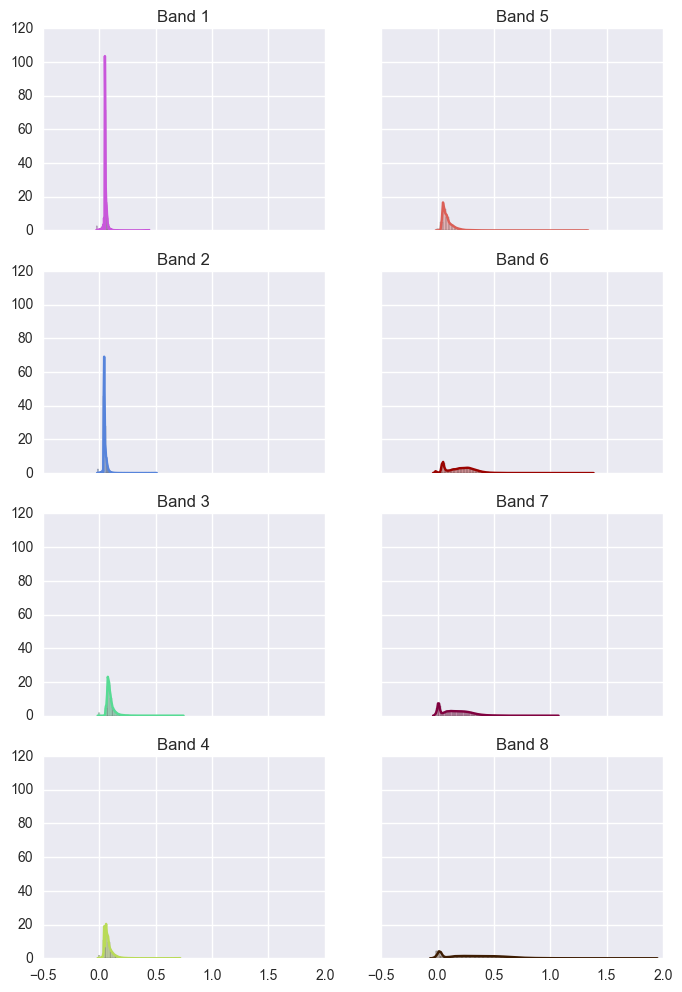

In [20]:
band_intensity_distributions(image)

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.misc import imresize

def band_covariance_plot(mbimage, scale_factor=10):
    """
    Given a multi-banded spectral image in the form of a (nbands, [image]) numpy array,
    downsample each image by scale_factor and plot the bivariate distributions of the 
    raw band intensities 
    """
    nbands, x, y = mbimage.shape
    cols = ["Band {}".format(i+1) for i in range(nbands)]
    nx, ny = np.floor(x/scale_factor), np.floor(y/scale_factor)
    data = np.rollaxis(np.vstack([imresize(mbimage[ind,:,:], (int(nx),int(ny))).ravel().squeeze() 
                                  for ind in range(nbands)]), 1, 0)
    df = pd.DataFrame(data, columns=cols)
    sns.pairplot(df)

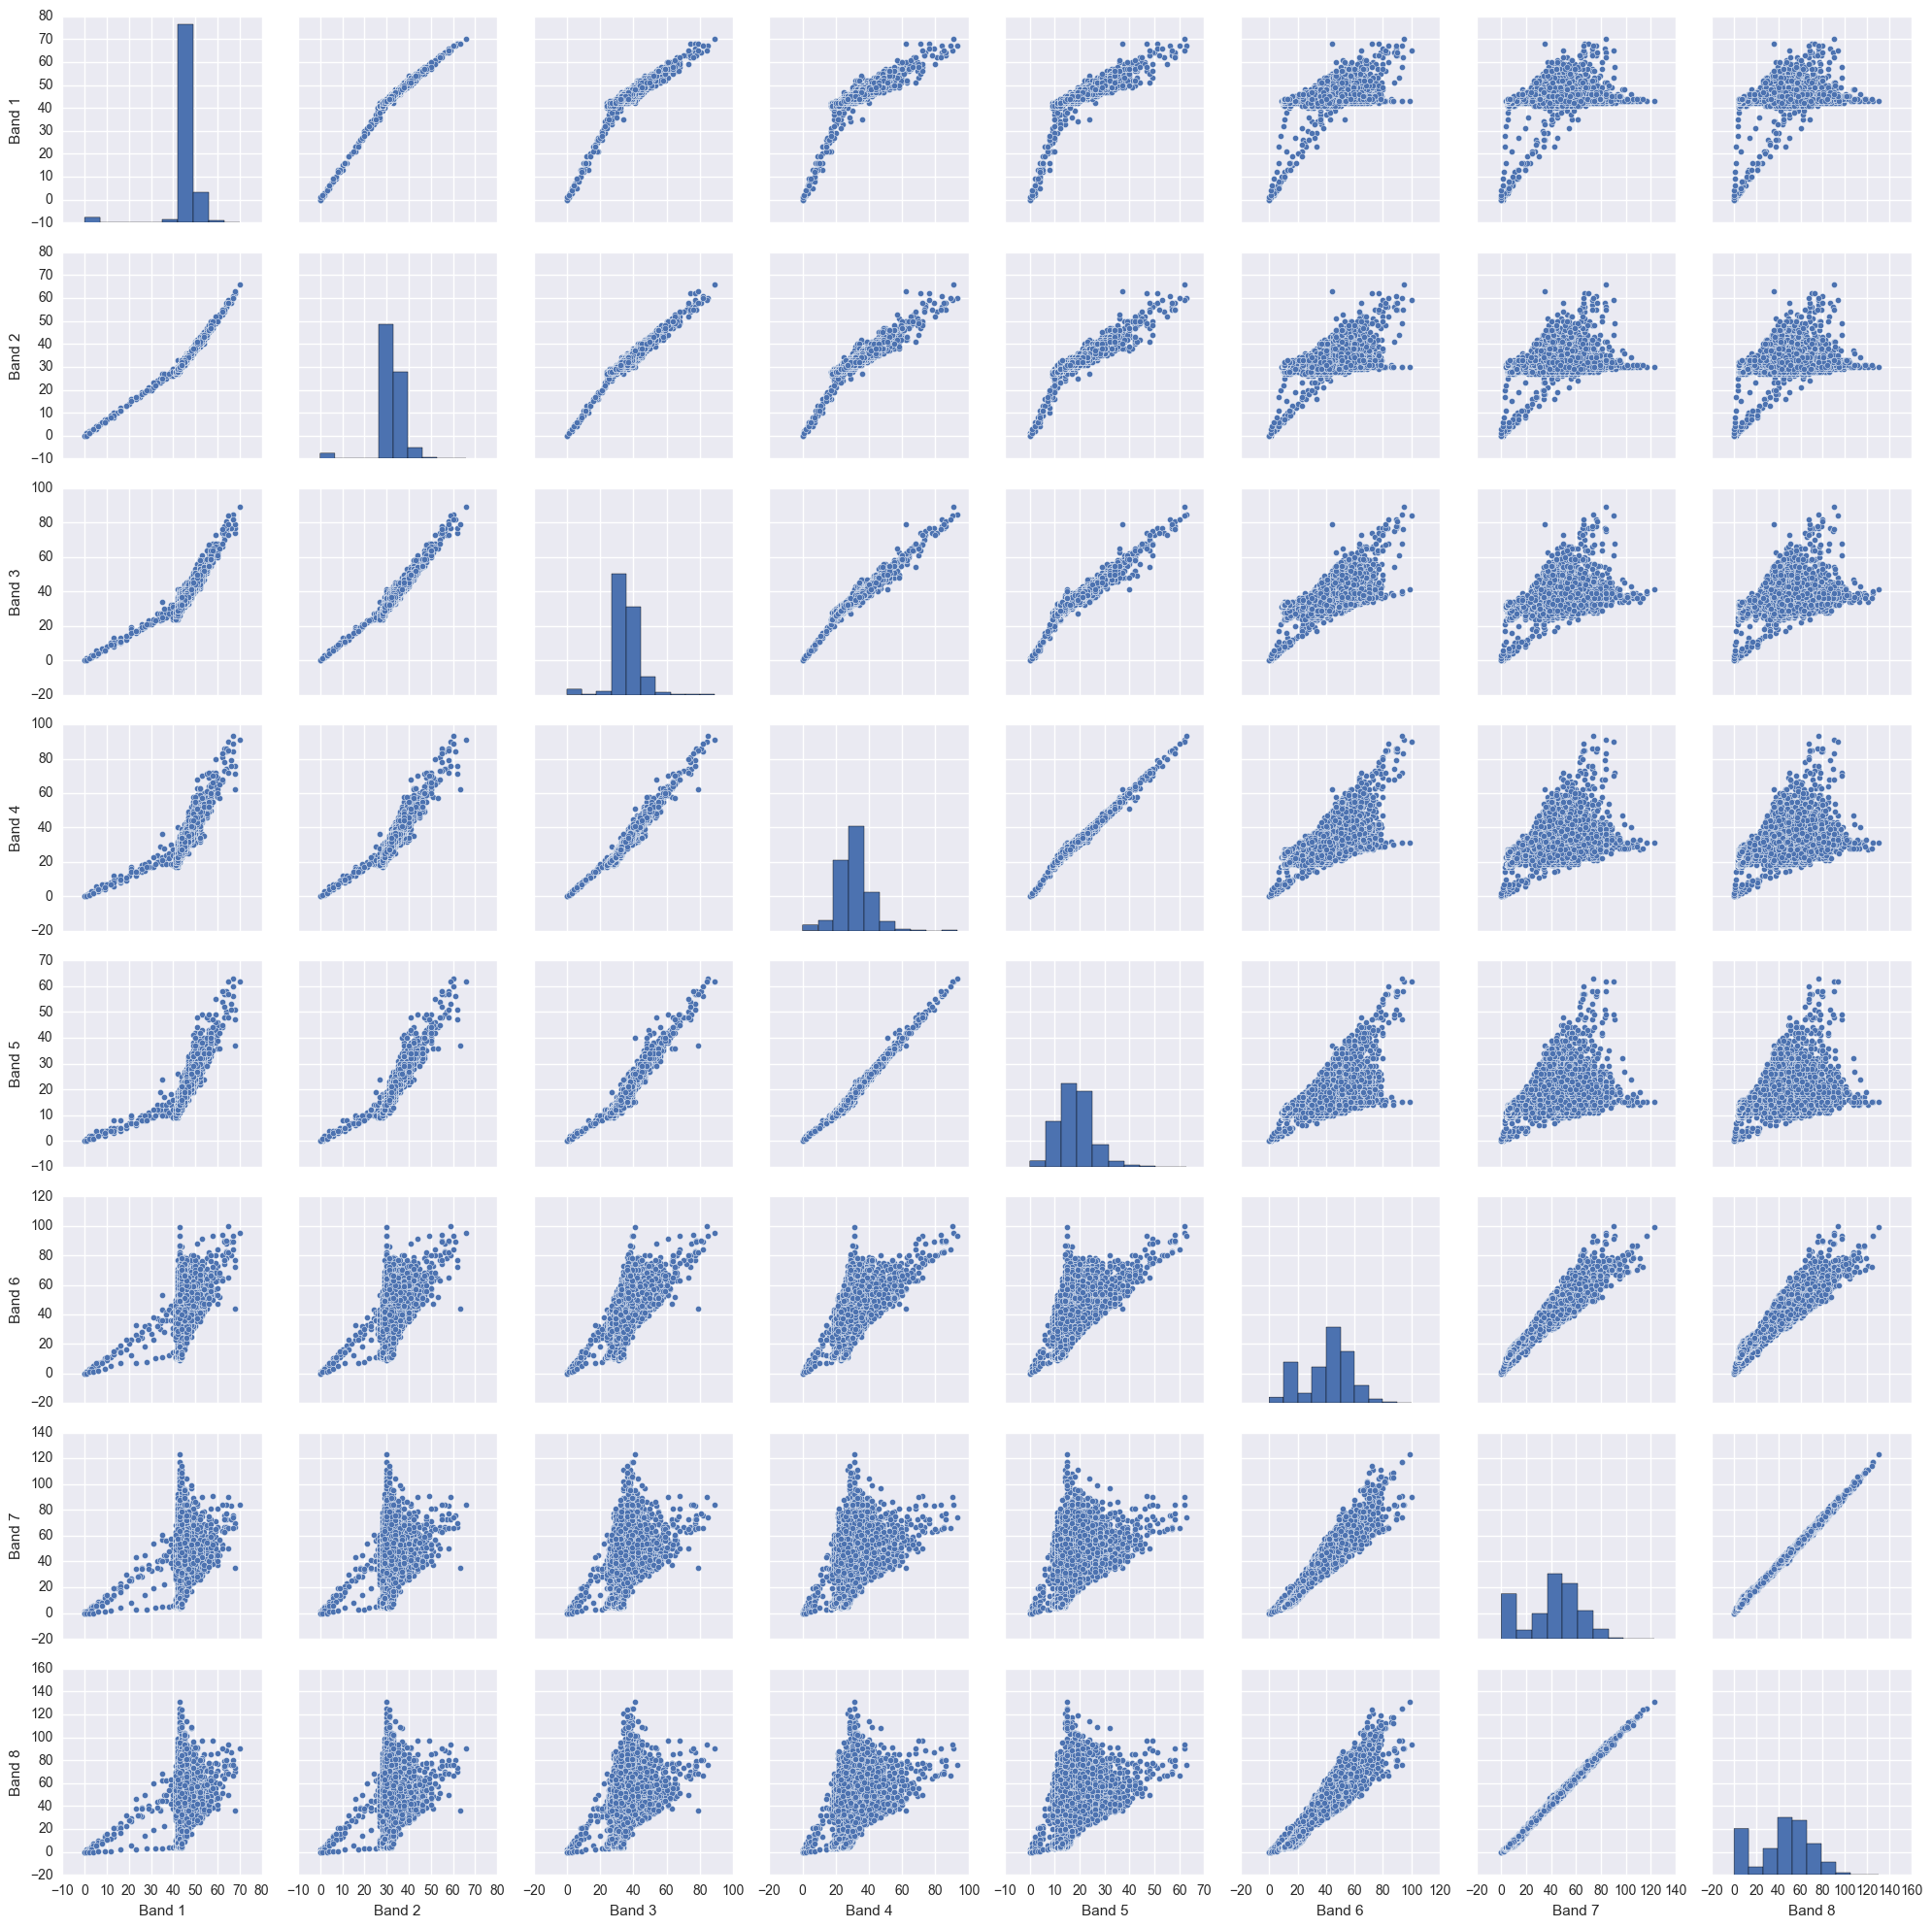

In [24]:
band_covariance_plot(dgsnap[0].read())

In [27]:
# Take red, green blue channels from a multispectral image and convert to uint8 RGB
def ms_to_rgb(mbimage):
    nbands, x, y = mbimage.shape
    if nbands == 8:
        rgb_uint8 = (np.dstack((mbimage[4,:,:], mbimage[2,:,:], mbimage[1,:,:])).clip(min=0) * 255.999).astype(np.uint8)
        return rgb_uint8


In [ ]:
# Display the image
# def display_raw(im, bands=[]):
#     nbands, x, y = im.shape
#     plt.axis("off")
#     plt.plot(im)

# def display_image(im, rbg=True, ):
#     nbands, x, y = im.shape
#     if 
#     plt.axis("off")
#     plt.imshow(rgb_uint8)


In [ ]:
# Clean up nicely when you're finished!
try:
    dgsnap.close()
    del dgsnap
except NameError:
    pass